In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
#import seaborn as sns
from tensorflow.keras.optimizers import Adam

In [2]:
df1 = pd.read_csv('/uscms_data/d3/jieun201/YOURWORKINGAREA/nov16_quantizeY/TrainSetWithIntegerYLocalAllUint8.csv')
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,y-local
0,0,0,1,2,3,1,1,0,0,0,0,0,0,4
1,0,0,1,2,3,1,0,0,0,0,0,0,0,3
2,0,0,0,2,7,1,0,0,0,0,0,0,0,11
3,0,0,0,0,5,6,5,2,0,0,0,0,0,2
4,0,0,0,0,0,4,7,0,0,0,0,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641955,0,0,1,2,34,0,0,0,0,0,0,0,0,11
1641956,0,0,0,0,3,3,0,0,0,0,0,0,0,10
1641957,0,0,0,2,8,9,9,11,3,0,0,0,0,1
1641958,0,0,0,0,0,8,27,0,0,0,0,0,0,9


In [3]:
df2 = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/nov12_multiclassifier_balancePT/TrainSetLabel.csv')
df2

,ptLabel
0,2
1,1
2,0
3,0
4,0
...,...
1641955,1
1641956,0
1641957,0
1641958,1


In [4]:
df3 = pd.read_csv('/uscms_data/d3/jieun201/YOURWORKINGAREA/nov16_quantizeY/TestSetWithIntegerYLocalAllUint8.csv')
df3

,0,1,2,3,4,5,6,7,8,9,10,11,12,y-local
0,0,0,0,3,3,11,12,6,0,0,0,0,0,3
1,0,0,0,0,0,0,6,0,0,0,0,0,0,9
2,0,0,0,9,7,0,0,0,0,0,0,0,0,7
3,0,0,0,0,0,1,15,9,0,0,0,0,0,7
4,0,0,0,1,3,4,3,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410483,0,0,0,0,10,10,0,0,0,0,0,0,0,8
410484,0,0,0,4,4,0,0,0,0,0,0,0,0,9
410485,0,0,0,0,0,6,11,1,0,0,0,0,0,7
410486,0,0,0,3,3,2,0,0,0,0,0,0,0,4


In [5]:
df4 = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/nov12_multiclassifier_balancePT/TestSetLabel.csv')
df4

,ptLabel
0,0
1,1
2,1
3,0
4,0
...,...
410483,0
410484,0
410485,1
410486,0


In [6]:
X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1641960, 14) (410488, 14) (1641960, 1) (410488, 1)


In [7]:
y_train

array([[2],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [9]:
X_test

array([[-0.08428001, -0.1550588 , -0.37066679, ..., -0.0631932 ,
        -0.05512388, -0.75421173],
       [-0.08428001, -0.1550588 , -0.37066679, ..., -0.0631932 ,
        -0.05512388,  1.03082143],
       [-0.08428001, -0.1550588 , -0.37066679, ..., -0.0631932 ,
        -0.05512388,  0.43581037],
       ...,
       [-0.08428001, -0.1550588 , -0.37066679, ..., -0.0631932 ,
        -0.05512388,  0.43581037],
       [-0.08428001, -0.1550588 , -0.37066679, ..., -0.0631932 ,
        -0.05512388, -0.45670621],
       [-0.08428001, -0.1550588 ,  3.55796297, ..., -0.0631932 ,
        -0.05512388, -1.34922278]])

In [10]:
from tensorflow.keras.layers import Input, Activation
from qkeras import *

def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
   #x = QActivation("quantized_bits(6,0)", name = "quantizeInputs")(x)
    x = QDense(128,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = QActivation("quantized_relu(10,0)", name="relu-1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model
    

model=CreateQModel(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()



2022-11-17 09:43:36.764508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 09:43:36.803136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 09:43:36.803491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 09:43:36.804916: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense1 (QDense)             (None, 128)               1920      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 relu-1 (QActivation)        (None, 128)               0         
                                                                 
 dense2 (QDense)             (None, 3)                 387       
                                                                 
 softmax (Activation)        (None, 3)                 0         
                                                             

In [11]:

es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)



Epoch 1/150
  62/1283 [>.............................] - ETA: 3s - loss: 1.0344 - sparse_categorical_accuracy: 0.4928 

2022-11-17 09:43:40.644090: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1283/1283 [==============================] - 5s 3ms/step - loss: 0.7819 - sparse_categorical_accuracy: 0.6335 - val_loss: 0.6740 - val_sparse_categorical_accuracy: 0.6939
Epoch 2/150
1283/1283 [==============================] - 4s 3ms/step - loss: 0.6600 - sparse_categorical_accuracy: 0.6983 - val_loss: 0.6434 - val_sparse_categorical_accuracy: 0.7076
Epoch 3/150
1283/1283 [==============================] - 4s 3ms/step - loss: 0.6431 - sparse_categorical_accuracy: 0.7050 - val_loss: 0.6320 - val_sparse_categorical_accuracy: 0.7085
Epoch 4/150
1283/1283 [==============================] - 4s 3ms/step - loss: 0.6355 - sparse_categorical_accuracy: 0.7077 - val_loss: 0.6311 - val_sparse_categorical_accuracy: 0.7118
Epoch 5/150
1283/1283 [==============================] - 4s 3ms/step - loss: 0.6317 - sparse_categorical_accuracy: 0.7091 - val_loss: 0.6283 - val_sparse_categorical_accuracy: 0.7103
Epoch 6/150
1283/1283 [==============================] - 4s 3ms/step - loss: 0.6284 - sparse_cate

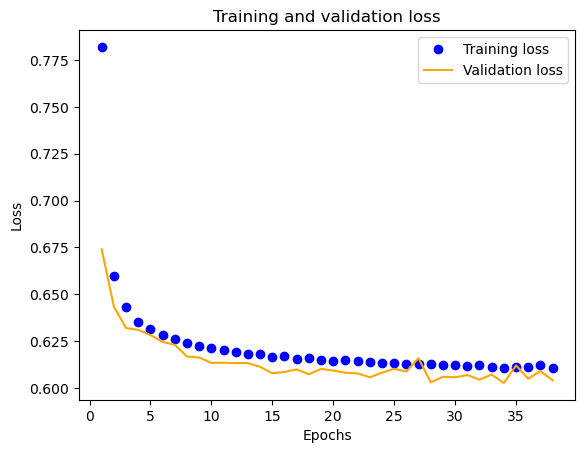

In [12]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

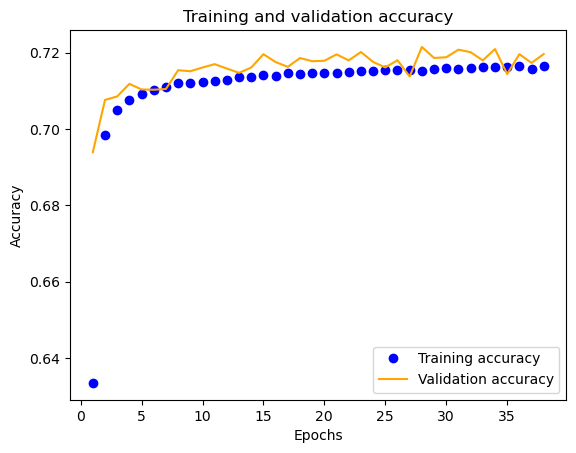

In [13]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig('accuracy.png')
plt.show()

In [14]:
preds = model.predict(X_test) 
predictionsFiles =np.argmax(preds, axis=1)

In [15]:
predictionsFiles

array([1, 1, 1, ..., 0, 0, 2])

In [16]:
pd.DataFrame(predictionsFiles).to_csv("predictionsFiles.csv",header='predict', index=False)

In [17]:
pd.DataFrame(y_test).to_csv("true.csv",header='true', index=False)

In [18]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6096779108047485
Test accuracy: 0.7196410298347473


Confusion matrix:
[[160951  22123  22170]
 [ 36124  65627    871]
 [ 33434    362  68826]]


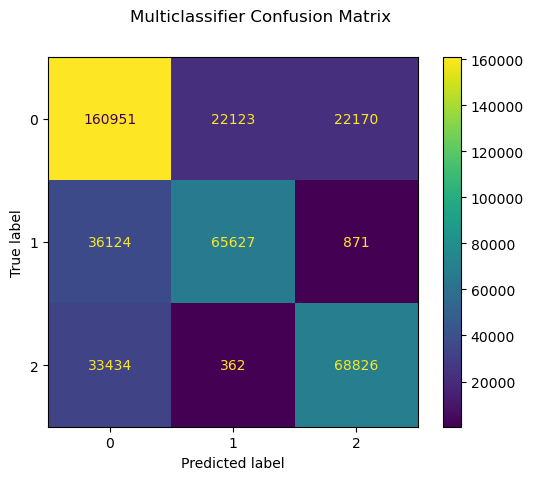

In [19]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('confusionMatrix.png')
plt.show()